In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfm, tfr = tf.math, tf.random

from scipy.stats import norm
from polyagamma import random_polyagamma

## Sampling PG random variables

In [2]:
__TRUNC = tf.constant(0.64, tf.float64)
__TRUNC_RECIP = tf.constant(1.0 / __TRUNC, tf.float64)
__PI = tf.constant(3.141592653589793238462643383279502884197, tf.float64)

In [3]:
@tf.function
def rtigauss(Z, dtype=tf.float64):
    Z = tfm.abs(Z)
    t = __TRUNC
    X = tf.zeros(tf.shape(Z), dtype) + (t + 1.0)

    alpha = tf.zeros(tf.shape(Z), dtype)
    flag11 = tfr.uniform(tf.shape(Z), dtype=dtype) > alpha

    while tf.reduce_any(flag11 == True):
        indices11 = tf.squeeze(tf.where(flag11 == True), -1)
    
        E1 = tf.cast(tfd.Exponential(1.0).sample(tf.shape(indices11)), dtype)
        E2 = tf.cast(tfd.Exponential(1.0).sample(tf.shape(indices11)), dtype)
    
        flag12 = E1*E1 > 2 * E2 / t
        while tf.reduce_any(flag12 == True):
            indices12 = tf.squeeze(tf.where(flag12 == True), -1)
            E1 = tf.tensor_scatter_nd_update(E1, indices12[:,None], tf.cast(tfd.Exponential(1.0).sample(tf.shape(indices12)), dtype))
            E2 = tf.tensor_scatter_nd_update(E2, indices12[:,None], tf.cast(tfd.Exponential(1.0).sample(tf.shape(indices12)), dtype))
            flag12 = E1*E1 > 2 * E2 / t

        X = tf.tensor_scatter_nd_update(X, indices11[:,None], t / ((1 + E1 * t) * (1 + E1 * t)))
        
        flag11 = tf.tensor_scatter_nd_update(flag11, indices11[:,None], tfr.uniform(tf.shape(indices11), dtype=dtype) > tf.gather(alpha, indices11))
        alpha = tf.where(flag11, tfm.exp(-0.5 * Z*Z * X), alpha)
        
    return X
   
Z = tf.constant([1.7,0.4,1.8,0.5,0.25], dtype=tf.float64)
rtigauss(Z)


2023-05-25 18:07:46.969821: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.45013698, 0.21829579, 0.22117513, 0.57744319, 0.35125528])>

In [4]:
@tf.function
def mass_texpon(Z):
    t = __TRUNC

    fz = 0.125 * __PI*__PI + 0.5 * Z*Z
    b = tf.cast(tfm.sqrt(1.0 / t) * (t * Z - 1), tf.float32)
    a = tf.cast(tfm.sqrt(1.0 / t) * (t * Z + 1) * -1.0, tf.float32)

    x0 = tfm.log(fz) + fz * t
    xb = x0 - Z + tf.cast(tfd.Normal(loc=0, scale=1).log_cdf(b), tf.float64)
    xa = x0 + Z + tf.cast(tfd.Normal(loc=0, scale=1).log_cdf(a), tf.float64)

    qdivp = 4 / __PI * ( tfm.exp(xb) + tfm.exp(xa) )

    return 1.0 / (1.0 + qdivp)

Z = tf.constant([1.7,0.4,1.8,0.5,0.25], dtype=tf.float64)
mass_texpon(Z)

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.29842956, 0.5572172 , 0.27517046, 0.54600383, 0.56961312])>

In [5]:
@tf.function
def a(n, X):
    n = tf.cast(n, tf.float64)
    K = (n + 0.5) * __PI
    y = tf.zeros(tf.shape(X), tf.float64)
    
    flag1 = ( X > __TRUNC )
    flag2 = tf.logical_and( X <= __TRUNC, X > 0 )

    indices1 = tf.squeeze(tf.where(flag1 == True), -1)
    indices2 = tf.squeeze(tf.where(flag2 == True), -1)

    X1 = tf.gather(X, indices1)
    X2 = tf.gather(X, indices2)
    
    y = tf.tensor_scatter_nd_update(y, indices1[:,None], K * tfm.exp( -0.5 * K*K * X1 ))
    y = tf.tensor_scatter_nd_update(y, indices2[:,None], tfm.exp( -1.5 * (tf.cast(tfm.log(0.5 * __PI), tf.float64) + tfm.log(X2)) + tf.cast(tfm.log(K), tf.float64) - 2.0 * (n+0.5)*(n+0.5) / X2 ))
    
    return y
        
X = tf.constant([0.2,0.4,0.8,0.5,0.7], dtype=tf.float64)
n = 0
a(n, X)    

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.73224913, 0.90361196, 0.5854481 , 0.83021499, 0.66231919])>

In [6]:
@tf.function
def draw_like_devroye(Z):
    # Change the parameter.
    Z = tfm.abs(Z) * 0.5

    # Now sample 0.25 * J^*(1, Z := Z/2).
    fz = 0.125 * __PI*__PI + 0.5 * Z*Z
    # ... Problems with large Z?  Try using q_over_p.
    # double p  = 0.5 * __PI * exp(-1.0 * fz * __TRUNC) / fz;
    # double q  = 2 * exp(-1.0 * Z) * pigauss(__TRUNC, Z);

    X = tf.zeros(Z.shape, tf.float64)
    S = tf.cast(1, tf.float64)
    Y = tf.cast(0, tf.float64)
    # int iter = 0; If you want to keep track of iterations.
    
    flag1 = tf.ones(Z.shape, tf.bool)
    while tf.reduce_any(flag1 == True):
        indices1 = tf.squeeze(tf.where(flag1 == True), -1)
        
        Z1 = tf.gather(Z, indices1)
        flag2 = tfr.uniform(tf.shape(Z1), dtype=tf.float64) < mass_texpon(Z1)

        indices21 = tf.squeeze(tf.where(flag2 == True), -1)
        indices22 = tf.squeeze(tf.where(flag2 == False), -1)

        X = tf.tensor_scatter_nd_update(X, indices21[:,None], ( __TRUNC + tf.cast(tfd.Exponential(1.0).sample(tf.shape(indices21)), tf.float64) / tf.gather(fz, indices21) ))
        X = tf.tensor_scatter_nd_update(X, indices22[:,None], ( rtigauss(tf.gather(Z1, indices22)) ))
    
        S = a(0, X)
        Y = tfr.uniform(tf.shape(X), dtype=tf.float64) * S
        n = 0
        go = flag1
        
        while tf.reduce_any(go == True):
            indices3 = tf.squeeze(tf.where(go == True), -1)
            
            # Break infinite loop.  Put first so it always checks n==0.
            #ifdef USE_R
            #if n % 1000 == 0:
            #    return -1

            n += 1
            
            if ( n % 2 == 1 ):
                S = S - a(n, X)
                          
                flag33 = ( Y <= S )
                indices33 = tf.squeeze(tf.where(flag33 == True), -1)
                          
                if tf.reduce_any(flag33 == True):
                    go = tf.tensor_scatter_nd_update(go, indices33[:,None], tf.zeros(tf.shape(indices33), tf.bool))
                    flag1 = tf.tensor_scatter_nd_update(flag1, indices33[:,None], tf.zeros(tf.shape(indices33), tf.bool))
            else:
                #print(tf.gather(S, indices3) + a(n, tf.gather(X, indices3)))
                S = S + a(n, X)
                          
                flag34 = ( Y > S )
                indices34 = tf.squeeze(tf.where(flag34 == True), -1)
                          
                if tf.reduce_any(flag34 == True):
                    go = tf.tensor_scatter_nd_update(go, indices34[:,None], tf.zeros(tf.shape(indices34), tf.bool))

        # Need Y <= S in event that Y = S, e.g. when X = 0.
    return 0.25 * X

Z = tf.constant([1.0,0.5,0.25], tf.float64)
draw_like_devroye(Z)


<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.08773415, 0.07223923, 0.35764522])>

In [7]:
#@tf.function
def multi_pgdraw(N, Z):
    def pgdraw(x):
        return draw_like_devroye(Z)
    max_N = tf.reduce_max(N)
    return tf.reduce_sum(tf.map_fn(pgdraw, tf.range(max_N), fn_output_signature=tf.float64) * tf.cast(tf.transpose(tf.sequence_mask(N, max_N)), tf.float64), axis=0)

N = tf.constant([6,5,15], tf.int64)
Z = tf.constant([1.65,0.5,0.25], tf.float64)
multi_pgdraw(N, Z)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1.41229292, 1.06471556, 3.91154018])>

## Demo polyagamma package

In [8]:
N = tf.constant([6,5,15], tf.int64)
Z = tf.constant([1.65,0.5,0.25], tf.float64)
np.array([random_polyagamma(n, z, disable_checks=True) for n,z in zip(N,Z)])

array([0.98459407, 0.92093287, 3.64374506])

## Compare PG-py versus PG-tf

In [12]:
m = 10000
Z = tfr.normal([m], 0, 1, tf.float64)
N = tfr.uniform(shape=(m,), minval=9, maxval=10, dtype=tf.int32)

xs = multi_pgdraw(N, Z)
xx = np.array([random_polyagamma(n, z, disable_checks=True) for n,z in zip(N,Z)])

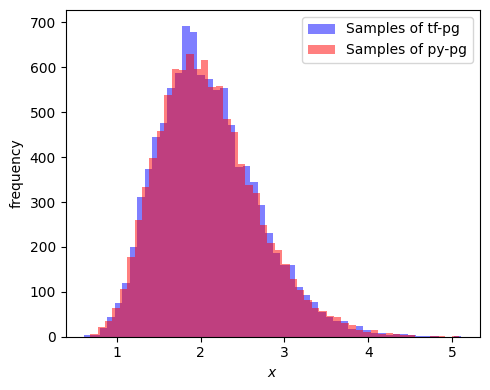

In [13]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(5,4))
plt.hist(xs, 50, color='b', alpha=0.5, label="Samples of tf-pg")
plt.hist(xx, 50, color='r', alpha=0.5, label="Samples of py-pg")
#plt.plot(xx, post, '-b', lw=2, label="$p(x | y)$")
ylim = plt.ylim()
#plt.plot([x_true, x_true], ylim, '-r', lw=2, label="True $x$")
plt.ylim(ylim)
plt.xlabel("$x$")
plt.ylabel("frequency")
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
#plt.savefig("aux/binomial.png")
plt.show()